In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
from IPython.display import clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

import tensorflow as tf
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Dense, BatchNormalization, ReLU, Concatenate
from tensorflow.keras.utils import plot_model

### Data Loading

In [2]:
main_data = pd.read_json('ml_metadata/movie_main_data_update.json')

main_data = main_data.reset_index()
main_data = main_data.rename(columns={'index': 'n_movie'})
main_data # (45463,17)

,n_movie,movie,movieId,release_date,example_age,genres,genresId,language,company,companyId,...,popularity,runtime,budget,revenue,vote_average,vote_count,cast,castId,crew,crewId
0,0,Toy Story,862,1995-10-30,0.012382,"Animation,Comedy,Family","16,35,10751",English,Pixar Animation Studios,3,...,21.946943,81.0,30000000,373554033.0,7.7,5415.0,"Tom Hanks,Tim Allen,Don Rickles,Jim Varney,Wal...","31,12898,7167,12899,12900,7907,8873,1116442,12...","John Lasseter,Joss Whedon,Andrew Stanton,Joel ...","7879,12891,7,12892,12893,12894,12895,12896,128..."
1,1,Jumanji,8844,1995-12-15,0.012382,"Adventure,Fantasy,Family","12,14,10751","English,Français","TriStar Pictures,Teitler Film,Interscope Commu...","559,2550,10201",...,17.015539,104.0,65000000,262797249.0,6.9,2413.0,"Robin Williams,Jonathan Hyde,Kirsten Dunst,Bra...","2157,8537,205,145151,5149,10739,58563,1276,465...","Larry J. Franco,Jonathan Hensleigh,James Horne...","511,876,1729,4945,4951,4952,8023,9967,9184,919..."
2,10,The American President,9087,1995-11-17,0.012382,"Comedy,Drama,Romance","35,18,10749",English,"Columbia Pictures,Castle Rock Entertainment","5,97",...,6.318445,106.0,62000000,107879496.0,6.5,199.0,"Michael Douglas,Annette Bening,Michael J. Fox,...","3392,516,521,8349,63279,112080,20767,19839,303...","John Seale,Rob Reiner,Rob Reiner,Robert Leight...","2702,3026,3026,3032,9251,13520"
3,100,Mr. Wrong,47475,1996-02-16,0.011887,"Comedy,Romance","35,10749",English,Touchstone Pictures,9195,...,3.329264,96.0,0,0.0,3.3,16.0,"Ellen DeGeneres,Bill Pullman,Joan Cusack,Dean ...","14,8984,3234,923,23709,15250,1232807,170162,12...",Nick Castle,14692
4,1000,Cool Runnings,864,1993-09-30,0.013373,Comedy,35,"English,Français,Deutsch,Pусский",Walt Disney,5888,...,8.307210,98.0,14000000,154864401.0,6.8,510.0,"Leon Robinson,Doug E. Doug,Rawle D. Lewis,Mali...","12974,12975,12976,12977,7180,10361,12978,12979...","Hans Zimmer,Phedon Papamichael,Jaki Brown,Dawn...","947,432,5776,11899,12962,12963,12964,12965,129..."
5,10000,Ride the Pink Horse,18871,1947-10-08,0.036157,"Drama,Mystery,Thriller","18,9648,53","English,Español",Universal International Pictures (UI),10330,...,3.432425,101.0,0,0.0,6.8,12.0,"Robert Montgomery,Wanda Hendrix,Andrea King,Th...","19406,83743,30952,18646,8632,14359,14976,83744...","Robert F. Boyle,Charles Lederer,Ben Hecht,Lesl...","2657,4358,4341,7654,12348,13809,14498,19406,29..."
6,10001,The Chant of Jimmie Blacksmith,69069,1978-06-21,0.020802,"Crime,Drama,History","80,18,36",English,"Victorian Film,The Film House","22046,34341",...,0.652960,113.0,1380000,0.0,6.7,10.0,"Tom E. Lewis,Freddy Reynolds,Ray Barrett,Jack ...","125533,555671,34657,12536,1355196,53548,212562...","Thomas Keneally,Ian Baker,Bruce Finlayson,Fred...","6685,27099,29790,64061,64061,64061,69980,10280..."
7,10002,Double Suicide,45713,1969-05-24,0.025260,"Drama,Romance,Foreign","18,10749,10769",日本語,"Art Theatre Guild,Hyôgen-sha","9181,21728",...,1.160174,104.0,0,0.0,6.5,14.0,"Kichiemon Nakamura,Shima Iwashita,Hôsei Komats...","133602,76976,133603,133604,96552,123854,133605...","Tôru Takemitsu,Tôru Takemitsu,Kôhei Oguri,Masa...","51808,51808,93078,133518,133518,133600,133601,..."
8,10003,Boy,104193,1969-07-26,0.025260,"Crime,Drama","80,18",日本語,"Art Theatre Guild,Sozosha","9181,9182",...,0.292384,105.0,0,0.0,7.0,8.0,"Fumio Watanabe,Akiko Koyama,Do-yun Yu,Tsuyoshi...","224662,552315,1016195,1429873","Nagisa Ōshima,Keiichi Uraoka,Tsutomu Tamura,Sh...","46230,46238,140624,552639,552639,1034270,10934..."
9,10004,Let Him Have It,64167,1991-10-04,0.014364,Drama,18,English,"Film Trustees Ltd.,Canal+,British Screen Produ...","1200,5358,20777",...,1.609107,115.0,0,0.0,6.5,15.0,"Christopher Eccleston,Paul Reynolds,Tom Courte...","2040,83553,14011,20300,63911,22169,20128,10780...","Robert Wade,Neal Purvis,Peter Medak","10783,10782,21377"


In [3]:
main_data_numerical = pd.read_json('ml_metadata/movie_main_data_numerical.json')
main_data_numerical = main_data_numerical[["movieId","movie","n_movie","example_age","genresId","popularity","runtime",
                                           "castId","crewId","vote_average","vote_count"]]
main_data_numerical.head() # (45202,9)

,movieId,movie,n_movie,example_age,genresId,popularity,runtime,castId,crewId,vote_average,vote_count
0,862,Toy Story,0,0.012382,"16,35,10751",21.946943,81,"31,12898,7167,12899,12900,7907,8873,1116442,12...","7879,12891,7,12892,12893,12894,12895,12896,128...",7.7,5415
1,8844,Jumanji,1,0.012382,"12,14,10751",17.015539,104,"2157,8537,205,145151,5149,10739,58563,1276,465...","511,876,1729,4945,4951,4952,8023,9967,9184,919...",6.9,2413
10,9087,The American President,10,0.012382,"35,18,10749",6.318445,106,"3392,516,521,8349,63279,112080,20767,19839,303...","2702,3026,3026,3032,9251,13520",6.5,199
100,47475,Mr. Wrong,100,0.011887,"35,10749",3.329264,96,"14,8984,3234,923,23709,15250,1232807,170162,12...",14692,3.3,16
1000,8367,Robin Hood: Prince of Thieves,1007,0.014364,12,10.639244,143,"1269,192,2224,1161,4566,8326,8316,8318,7486,83...","2182,2182,2184,2185,2185,7714,8307,8306,8300",6.6,937


In [4]:
ratings = pd.read_json('ml_metadata/ratings.json')
ratings['userId']=ratings['userId'].astype(int)
ratings['movieId']=ratings['movieId'].astype(int)
ratings = ratings[(ratings.userId <= 10000)]
ratings.head(3) # (978527,4)

,userId,movieId,rating,timestamp
0,1,110,1.0,0.893442
1,1,147,4.5,0.893443
10,1,4878,5.0,0.893442


##### Preprocessed data

In [5]:
data_recall = pd.read_json('ml_metadata/data_10000_update.json')
data_recall.head(1) # (9827,14)

,userId,n_movie,watch_hist,labels,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count
0,1,"[302, 11491, 1409, 2108, 11967, 26065, 30754, ...","[302, 11491, 1409, 2108, 11967, 26065, 30754, ...",[2627],"[0.0128776622, 0.0069341258000000005, 0.011391...","[18,9648,10749, 18, 18,35,10749, 18,80, 35, 35...","[1.0, 5.0, 4.0, 4.5, 4.0, 4.0, 3.5, 4.0, 5.0, ...","[0.8934418709, 0.8934419088000001, 0.89344274,...","[7.832755, 11.697604, 6.285574, 3.824884, 7.10...","[99.0, 102.0, 109.0, 83.0, 91.0, 86.0, 87.0, 1...","[1350,1352,1356,1354,49025,27983,1145,1137,114...","[1126,1126,1126,1132,1132,1134,1135,1136,1346,...","[7.8, 6.5, 5.8, 6.8, 5.3, 4.8, 5.9, 4.9, 6.6, ...","[246.0, 858.0, 133.0, 42.0, 258.0, 70.0, 5.0, ..."


In [6]:
train_data = data_recall[(data_recall.userId >= 1)&(data_recall.userId <= 9000)]
test_data = data_recall[(data_recall.userId >= 9001)&(data_recall.userId <= 10000)]
test_data.head(5)

,userId,n_movie,watch_hist,labels,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count
8845,9001,"[895, 302]",[895],[302],[0.0331847449],"[35,10749, 18,9648,10749]","[5.0, 5.0]","[0.2650458263, 0.26504575610000003]","[11.954806, 7.832755]","[119.0, 99.0]","[8487,1932,11998,11999,12000,12001,12002,12003...","[10001,11993,11994,11995,10001,11996,2578,2307...","[7.8, 7.8]","[502.0, 246.0]"
8846,9002,"[24355, 11604, 2975, 3224, 10758, 2306, 897, 2...","[24355, 11604, 2975, 3224, 10758, 2306, 897, 2...",[24520],"[0.0074294205000000006, 0.0064388311, 0.010401...","[35,80, 35, 18,14,53,9648, 35,18,10749, 18,35,...","[4.0, 3.0, 3.0, 3.0, 3.0, 2.0, 4.0, 2.0, 4.0, ...","[0.25775619650000003, 0.25775648160000003, 0.2...","[4.522887, 14.764607, 11.072361, 4.67546, 2.67...","[91.0, 102.0, 105.0, 97.0, 110.0, 91.0, 113.0,...","[10847,17163,19024,19854,12089,15601,1152,2118...","[10847,10847, 7145,11506,16852,16853,16853,168...","[5.5, 5.8, 6.9, 5.8, 7.1, 6.6, 6.8, 5.3, 7.6, ...","[37.0, 194.0, 1774.0, 17.0, 25.0, 984.0, 66.0,..."
8847,9003,"[14185, 4936, 5880, 24105, 12414, 12260, 8181,...","[14185, 4936, 5880, 24105, 12414, 12260, 8181,...",[25544],"[0.0267459138, 0.018821198600000002, 0.0089153...","[35, 53,28,35,80,18, 18, 99, 28,12,35, 12,14, ...","[5.0, 5.0, 5.0, 5.0, 2.0, 5.0, 5.0, 1.0, 5.0, ...","[0.5195605237, 0.5195607469, 0.5195607427, 0.5...","[6.9336459999999995, 15.297121, 14.686487, 0.1...","[87.0, 96.0, 114.0, 90.0, 110.0, 113.0, 126.0,...","[40948,40941,40945,40944,40950,40949,40951,128...","[8934,40940,40959,41828,41829,41830, 909,1091,...","[7.0, 6.5, 7.0, 8.0, 7.1, 5.8, 7.2, 6.9, 7.3, ...","[33.0, 364.0, 461.0, 1.0, 32.0, 1347.0, 295.0,..."
8848,9004,"[897, 29071, 5190, 1016]","[897, 29071, 5190]",[1016],"[0.037642397200000004, 0.0074294205000000006, ...","[35,10402,10749, 35, 18,36, 28,53]","[1.0, 4.0, 4.5, 3.0]","[0.6744767535, 0.6744768041, 0.6744765907, 0.6...","[7.331511, 0.9330109999999999, 6.130177, 16.64...","[113.0, 97.0, 100.0, 131.0]","[9066,13991,13992,13993,13994,13995,13996,1150...","[13980,7662,13981,13982,9055,13288,13983,12307...","[6.8, 3.8, 7.9, 7.5]","[66.0, 8.0, 123.0, 4005.0]"
8849,9005,"[2144, 4606, 4856, 5211, 4753, 5088, 10125, 29...","[2144, 4606, 4856, 5211, 4753, 5088, 10125, 2989]",[2658],"[0.0158494304, 0.009410599300000001, 0.0371471...","[35,80,10749, 35,10749, 80,18,9648, 99, 28,18,...","[4.0, 3.0, 5.0, 4.5, 3.0, 5.0, 4.0, 4.5, 4.0]","[0.46048096780000003, 0.4604810212, 0.46048099...","[5.611184, 10.25103, 4.496034, 4.704091, 9.807...","[104.0, 108.0, 97.0, 91.0, 131.0, 130.0, 86.0,...","[1160,8654,17485,7447,923,2167,3234,1219901,15...","[557,1530,3078,3104,16294,16296,16297,16298,16...","[5.8, 6.0, 6.7, 7.2, 7.0, 6.0, 6.6, 7.8, 7.7]","[67.0, 1375.0, 58.0, 53.0, 290.0, 16.0, 3322.0..."


In [7]:
# user_9488 Once Were Warriors
# user_9788 Madagascar
result = main_data[["movie"]]

USER=9682
rcmd=test_data[(test_data.userId == USER)]
print("Recommend user "+str(USER)+"   label:  "+result["movie"][rcmd["labels"][(rcmd[rcmd['userId']==USER].index.values[0])][0]])


brian=""
for ii in (rcmd["genresId"][(rcmd[rcmd['userId']==USER].index.values[0])]):
    brian+=ii+","   
brian= brian.strip(",")
rcmd["genresId"][(rcmd[rcmd['userId']==USER].index.values[0])]=brian   

rcmd["genresId"]=rcmd["genresId"].apply(lambda x:x.split(","))
rcmd["genresId"]=rcmd["genresId"].apply(lambda x: [int(i)for i in x if len(i) != 0])

brian=""
for ii in (rcmd["castId"][(rcmd[rcmd['userId']==USER].index.values[0])]):
    brian+=ii+","   
brian= brian.strip(",")
rcmd["castId"][(rcmd[rcmd['userId']==USER].index.values[0])]=brian   

rcmd["castId"]=rcmd["castId"].apply(lambda x:x.split(","))
rcmd["castId"]=rcmd["castId"].apply(lambda x: [int(i)for i in x if len(i) != 0])

# brian=""
for ii in (rcmd["crewId"][(rcmd[rcmd['userId']==USER].index.values[0])]):
    brian+=ii+","   
brian= brian.strip(",")
rcmd["crewId"][(rcmd[rcmd['userId']==USER].index.values[0])]=brian   

rcmd["crewId"]=rcmd["crewId"].apply(lambda x:x.split(","))
rcmd["crewId"]=rcmd["crewId"].apply(lambda x: [int(i)for i in x if len(i) != 0])

rcmd["train"]=rcmd["watch_hist"]
rcmd["test"]=rcmd["watch_hist"]

rcmd["train"][(rcmd[rcmd['userId']==USER].index.values[0])]=rcmd["watch_hist"][(rcmd[rcmd['userId']==USER].index.values[0])][:200]
rcmd["test"][(rcmd[rcmd['userId']==USER].index.values[0])]=rcmd["watch_hist"][(rcmd[rcmd['userId']==USER].index.values[0])][200:]

clear_output()
rcmd


,userId,n_movie,watch_hist,labels,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count,train,test
9514,9682,"[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...","[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...",[1038],"[0.0069341258000000005, 0.0074294205000000006,...","[18, 36, 10752, 12, 14, 10751, 35, 35, 18, 18,...","[1.0, 3.0, 4.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ...","[0.2237489728, 0.2237762245, 0.223775945, 0.22...","[10.021547, 24.903058, 0.696229, 4.19275, 2.61...","[128.0, 157.0, 94.0, 81.0, 109.0, 107.0, 117.0...","[2408, 20666, 20442, 20667, 20668, 20669, 2067...","[2408, 20666, 20442, 20667, 20668, 20669, 2067...","[6.7, 7.5, 4.3, 6.4, 7.6, 6.3, 7.0, 6.7, 5.9, ...","[96.0, 5758.0, 2.0, 64.0, 46.0, 320.0, 246.0, ...","[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...","[1912, 11162, 1119, 4074, 3300, 7760, 10995, 2..."


In [8]:

USER_2=9788
rcmd_2=test_data[(test_data.userId == USER_2)]
print("Recommend user "+str(USER_2)+"   label:  "+result["movie"][rcmd_2["labels"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])][0]])
rcmd_2["train"]=rcmd_2["watch_hist"]
rcmd_2["test"]=rcmd_2["watch_hist"]
rcmd_2["train"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])]=rcmd_2["watch_hist"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])][:200]
rcmd_2["test"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])]=rcmd_2["watch_hist"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])][200:]

USER_3=9164
rcmd_3=test_data[(test_data.userId == USER_3)]
print("Recommend user "+str(USER_3)+"   label:  "+result["movie"][rcmd_3["labels"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])][0]])
rcmd_3["train"]=rcmd_3["watch_hist"]
rcmd_3["test"]=rcmd_3["watch_hist"]
rcmd_3["train"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])]=rcmd_3["watch_hist"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])][:200]
rcmd_3["test"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])]=rcmd_3["watch_hist"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])][200:]

USER_4=9279
rcmd_4=test_data[(test_data.userId == USER_4)]
print("Recommend user "+str(USER_4)+"   label:  "+result["movie"][rcmd_4["labels"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])][0]])
rcmd_4["train"]=rcmd_4["watch_hist"]
rcmd_4["test"]=rcmd_4["watch_hist"]
rcmd_4["train"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])]=rcmd_4["watch_hist"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])][:200]
rcmd_4["test"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])]=rcmd_4["watch_hist"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])][200:]

USER_5=9488
rcmd_5=test_data[(test_data.userId == USER_5)]
print("Recommend user "+str(USER_5)+"   label:  "+result["movie"][rcmd_5["labels"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])][0]])
rcmd_5["train"]=rcmd_5["watch_hist"]
rcmd_5["test"]=rcmd_5["watch_hist"]
rcmd_5["train"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])]=rcmd_5["watch_hist"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])][:200]
rcmd_5["test"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])]=rcmd_5["watch_hist"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])][200:]
clear_output()

In [9]:
rcmd

,userId,n_movie,watch_hist,labels,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count,train,test
9514,9682,"[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...","[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...",[1038],"[0.0069341258000000005, 0.0074294205000000006,...","[18, 36, 10752, 12, 14, 10751, 35, 35, 18, 18,...","[1.0, 3.0, 4.0, 2.0, 5.0, 4.0, 5.0, 5.0, 5.0, ...","[0.2237489728, 0.2237762245, 0.223775945, 0.22...","[10.021547, 24.903058, 0.696229, 4.19275, 2.61...","[128.0, 157.0, 94.0, 81.0, 109.0, 107.0, 117.0...","[2408, 20666, 20442, 20667, 20668, 20669, 2067...","[2408, 20666, 20442, 20667, 20668, 20669, 2067...","[6.7, 7.5, 4.3, 6.4, 7.6, 6.3, 7.0, 6.7, 5.9, ...","[96.0, 5758.0, 2.0, 64.0, 46.0, 320.0, 246.0, ...","[11628, 10593, 43911, 6761, 8351, 1791, 2603, ...","[1912, 11162, 1119, 4074, 3300, 7760, 10995, 2..."


In [10]:
# ex_test={"watch_hist":[[45526, 45509, 45158, 45227,
#                        45461, 45331, 45341, 45446, 45425]],
#          "example_age":[[0.002476, 0.001486, 0.001486, 0.001981,
#                         0.002476, 0.001486, 0.001486, 0.001981, 0.001486]]}
# rcmd_ex=pd.DataFrame(ex_test)

# #45526 2015 0.002476
# #45509 2017 0.001486
# #45158 2017 0.001486
# #45227 2016 0.001981

# #45461 2015 0.002476
# #45331 2017 0.001486
# #45341 2017 0.001486
# #45446 2016 0.001981
# #45452 2017 0.001486
# rcmd_ex

### Candidate generation

In [11]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 64
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=45537
LEARNING_RATE = 0.001

In [12]:
class MaskedEmbeddingsAggregatorLayer(tf.keras.layers.Layer):
    def __init__(self, agg_mode='sum', **kwargs):
        super(MaskedEmbeddingsAggregatorLayer, self).__init__(**kwargs)

        if agg_mode not in ['sum', 'mean']:
            raise NotImplementedError('mode {} not implemented!'.format(agg_mode))
        self.agg_mode = agg_mode
    
    @tf.function
    def call(self, inputs, mask=None):
        masked_embeddings = tf.ragged.boolean_mask(inputs, mask)
        if self.agg_mode == 'sum':
            aggregated =  tf.reduce_sum(masked_embeddings, axis=1)
        elif self.agg_mode == 'mean':
            aggregated = tf.reduce_mean(masked_embeddings, axis=1)
        return aggregated
    
    def get_config(self):
        # this is used when loading a saved model that uses a custom layer
        return {'agg_mode': self.agg_mode}
    
class L2NormLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L2NormLayer, self).__init__(**kwargs)
    
    @tf.function
    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.ragged.boolean_mask(inputs, mask).to_tensor()
        return tf.math.l2_normalize(inputs, axis=-1)

    def compute_mask(self, inputs, mask):
        return mask

In [13]:
avg_embeddings = MaskedEmbeddingsAggregatorLayer(agg_mode='mean', name='aggregate_embeddings')
l2_norm_1 = L2NormLayer(name='l2_norm_1')

In [14]:
# Input layer
input_watch_hist = tf.keras.Input(shape=(None, ), name='watch_hist')
input_example_age = tf.keras.Input(shape=(None, ), name='example_age')

# Embedding layer 
features_embedding_layer=Embedding(input_dim=45537,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='features_embeddings')
features_embeddings = features_embedding_layer(input_watch_hist)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_embedding_layer=Embedding(input_dim=200,output_dim=EMBEDDING_DIMS,mask_zero=True,trainable=True,name='labels_embeddings')
labels_example_age_embeddings = labels_embedding_layer(input_example_age)
l2_norm_example_age = l2_norm_1(labels_example_age_embeddings)
avg_example_age = avg_embeddings(l2_norm_example_age)
# avg_example_age = avg_embeddings(labels_example_age_embeddings)


# Combine 2 branches
# concat_inputs = Concatenate(axis=1)([avg_features]) # 
concat_inputs = Concatenate(axis=1)([avg_features, avg_example_age])

# Dense layer
dense_1 = Dense(units=DENSE_UNITS*2, name='dense_1')
dense_1_features = dense_1(concat_inputs)
dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
dense_3_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

# dense_2 = Dense(units=DENSE_UNITS*1, name='dense_2')
# dense_2_features = dense_2(dense_1_batch_norm)
# dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
# dense_2_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

# dense_3 = Dense(units=DENSE_UNITS, name='dense_3')
# dense_3_features = dense_3(dense_2_batch_norm)
# dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)
# dense_3_batch_norm = BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)

# Output layer
dense_output = Dense(NUM_CLASSES, activation='softmax', name='dense_output')
outputs = dense_output(dense_3_batch_norm)
# outputs = dense_output(dense_3_relu)

# Model
model = tf.keras.models.Model(
        inputs=[input_watch_hist, input_example_age],
        outputs=[outputs])

optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])

model.summary()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
reduction_indices is deprecated, use axis instead
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
watch_hist (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
example_age (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
features_embeddings (

In [15]:
# plot_model(model,rankdir="LR")

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [16]:
EPOCH = 20 # 100
history=model.fit([pad_sequences(train_data['watch_hist'])+ 1e-10,
                  pad_sequences(train_data['example_age'],dtype=float)+ 1e-10,
                  ],
                  pad_sequences(train_data['labels']),
                  batch_size=1024, 
                  validation_split=0.1, 
                  epochs=EPOCH,
                  verbose=1)

Train on 7960 samples, validate on 885 samples
Epoch 1/20
7960/7960 [==============================] - 15s 2ms/sample - loss: 10.7198 - acc: 0.0026 - val_loss: 10.7000 - val_acc: 0.0136
Epoch 2/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.6910 - acc: 0.0127 - val_loss: 10.6520 - val_acc: 0.0136
Epoch 3/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.6421 - acc: 0.0153 - val_loss: 10.5629 - val_acc: 0.0136
Epoch 4/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.5598 - acc: 0.0151 - val_loss: 10.4142 - val_acc: 0.0136
Epoch 5/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.4333 - acc: 0.0146 - val_loss: 10.1908 - val_acc: 0.0136
Epoch 6/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.2547 - acc: 0.0149 - val_loss: 9.8711 - val_acc: 0.0136
Epoch 7/20
7960/7960 [==============================] - 14s 2ms/sample - loss: 10.0160 - acc: 0.0146 - val_loss: 9.4560 

Text(0.5, 1.0, 'Recall')

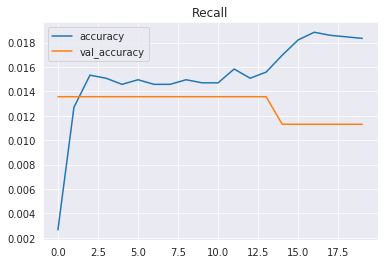

In [17]:
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.legend(loc='upper left')
# plt.ylim(0.001,0.021)
plt.title(f'Recall')

Text(0.5, 1.0, 'Recall')

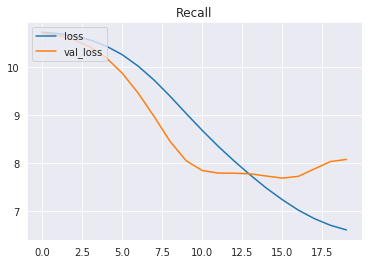

In [18]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend(loc='upper left')
# plt.ylim(7.9,11.4)
plt.title(f'Recall')

In [19]:
rcmd_recall= model.predict([pad_sequences(rcmd['train'])+ 1e-10,
                            pad_sequences(rcmd['example_age'],dtype=float)+ 1e-10,
                            ])

rcmd_recall_2= model.predict([pad_sequences(rcmd_2['train'])+ 1e-10,
                              pad_sequences(rcmd_2['example_age'],dtype=float)+ 1e-10,
                              ])

rcmd_recall_3= model.predict([pad_sequences(rcmd_3['train'])+ 1e-10,
                              pad_sequences(rcmd_3['example_age'],dtype=float)+ 1e-10,
                              ])

rcmd_recall_4= model.predict([pad_sequences(rcmd_4['train'])+ 1e-10,
                              pad_sequences(rcmd_4['example_age'],dtype=float)+ 1e-10,
                              ])

rcmd_recall_5= model.predict([pad_sequences(rcmd_5['train'])+ 1e-10,
                              pad_sequences(rcmd_5['example_age'],dtype=float)+ 1e-10,
                              ])
rcmd_recall.shape

(1, 45537)

In [20]:
# rcmd_ex_recall= model.predict([pad_sequences(rcmd_ex['watch_hist'])+ 1e-10,
#                             pad_sequences(rcmd_ex['example_age'],dtype=float)+ 1e-10,
#                             ])
# N = 10
# k = (rcmd_ex_recall).argsort()[:,:N]
# k = k[0]
# print(k)

# print("Recommend:")
# for i in k:
#     print("  "+ result["movie"][i])

# 2000, 1968, 1982, 1994
#  Confession of a Child of the Century 2012

In [21]:
N = 100
k = (rcmd_recall).argsort()[:,:N]
k = k[0]
print(k)

k_2 = (rcmd_recall_2).argsort()[:,:N]
k_2 = k_2[0]
print(k_2)

k_3 = (rcmd_recall_3).argsort()[:,:N]
k_3 = k_3[0]
print(k_3)

k_4 = (rcmd_recall_4).argsort()[:,:N]
k_4 = k_4[0]
print(k_4)

k_5 = (rcmd_recall_5).argsort()[:,:N]
k_5 = k_5[0]
print(k_5)

[ 4031   944  5315   286  3393   534 37798  5021  2260  4936    15 10995
  5264  5880  1744  6382  3813  6494 12024 11860  4765  3834  8772  2989
  1173 11018  3897  4606  4153  5845 33994 44219  6109  4783  6417  2183
  5304    14  8647  6967 11967  3224  7200  2199 16620  9554  1109 10577
 34559  6862   302  2224 41598    28 11772  1409 11305 32248 11047 22310
  3783  7223  1016  7757  6389 11440  7633 22587  5189  6419  5179  2108
 30362 11399  1224 12337 13271 10556 12131  4532   223 44848  6053  2653
 20816  9575  5088   787  6742  3904   638  7072 17003  7020   510  1243
 33785  9515  3891  2437]
[ 4031   944  5315   286  3393   534 37798  5021  2260  4936    15 10995
  5264  5880  1744 12024  6494  6382  3813 11860  4765  1173  8772  3834
 11018  2989  3897  4606 33994  4153 44219  6417  5845  6109  4783 11967
  5304  2183    14  8647  6967  3224  7200 10577  6862  2199  1109 16620
  9554   302 34559  1409    28  2224 11772 41598 11047 32248 11305  7757
 22310  7223  2108  6389 

In [22]:
print("Label:")
print("   "+result["movie"][rcmd["labels"][(rcmd[rcmd['userId']==USER].index.values[0])][0]])

print("Recommend:")
# for i in k:
#     print("  "+ result["movie"][i])
print("   break")    

print("User_"+str(USER)+" watched:")
t=0
for i in (rcmd["test"][(rcmd[rcmd['userId']==USER].index.values[0])]):
#     print(i)
    for j in k:
        if i == j:
            t+=1
#             print("  "+ result["movie"][i])
print("   break")
# result["movie"][rcmd["labels"][(rcmd[rcmd['userId']==9932].index.values[0])][0]]

            
print("rcmd_acc: "+str(t/len(k)))




print("\nLabel:")
print("   "+result["movie"][rcmd_2["labels"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])][0]])

print("Recommend:")
# for i in k_2:
#     print("  "+ result["movie"][i])
print("   break")    

print("User_"+str(USER_2)+" watched:")
tt=0
for i in (rcmd_2["test"][(rcmd_2[rcmd_2['userId']==USER_2].index.values[0])]):
#     print(i)
    for j in k_2:
        if i == j:
            tt+=1
#             print("  "+ result["movie"][i])
print("   break")
         
print("rcmd_2_acc: "+str(tt/len(k_2)))




print("\nLabel:")
print("   "+result["movie"][rcmd_3["labels"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])][0]])

print("Recommend:")
# for i in k_3:
#     print("  "+ result["movie"][i])
print("   break")    

print("User_"+str(USER_3)+" watched:")
ttt=0
for i in (rcmd_3["test"][(rcmd_3[rcmd_3['userId']==USER_3].index.values[0])]):
#     print(i)
    for j in k_3:
        if i == j:
            ttt+=1
#             print("  "+ result["movie"][i])
print("   break")
         
print("rcmd_3_acc: "+str(ttt/len(k_3)))




print("\nLabel:")
print("   "+result["movie"][rcmd_4["labels"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])][0]])

print("Recommend:")
# for i in k_4:
#     print("  "+ result["movie"][i])
print("   break")    

print("User_"+str(USER_4)+" watched:")
tttt=0
for i in (rcmd_4["test"][(rcmd_4[rcmd_4['userId']==USER_4].index.values[0])]):
#     print(i)
    for j in k_4:
        if i == j:
            tttt+=1
#             print("  "+ result["movie"][i])
print("   break")
         
print("rcmd_4_acc: "+str(tttt/len(k_4)))



print("\nLabel:")
print("   "+result["movie"][rcmd_5["labels"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])][0]])

print("Recommend:")
# for i in k_5:
#     print("  "+ result["movie"][i])
print("   break")    

print("User_"+str(USER_5)+" watched:")
ttttt=0
for i in (rcmd_5["test"][(rcmd_5[rcmd_5['userId']==USER_5].index.values[0])]):
#     print(i)
    for j in k_5:
        if i == j:
            ttttt+=1
#             print("  "+ result["movie"][i])
print("   break")
         
print("rcmd_5_acc: "+str(ttttt/len(k_5)))


mean_acc=((t/len(k))+(tt/len(k_2))+(ttt/len(k_3))+(tttt/len(k_4))+(ttttt/len(k_5)))/5
print("\nrecall_acc: "+'%.3f'%mean_acc)


Label:
   Stay Alive
Recommend:
   break
User_9682 watched:
   break
rcmd_acc: 0.4

Label:
   Armageddon
Recommend:
   break
User_9788 watched:
   break
rcmd_2_acc: 0.57

Label:
   The Haunting of Molly Hartley
Recommend:
   break
User_9164 watched:
   break
rcmd_3_acc: 0.35

Label:
   Patton
Recommend:
   break
User_9279 watched:
   break
rcmd_4_acc: 0.3

Label:
   Falling Up
Recommend:
   break
User_9488 watched:
   break
rcmd_5_acc: 0.47

recall_acc: 0.418


### Ranking

In [23]:
main_data_numerical.head(3)

,movieId,movie,n_movie,example_age,genresId,popularity,runtime,castId,crewId,vote_average,vote_count
0,862,Toy Story,0,0.012382,"16,35,10751",21.946943,81,"31,12898,7167,12899,12900,7907,8873,1116442,12...","7879,12891,7,12892,12893,12894,12895,12896,128...",7.7,5415
1,8844,Jumanji,1,0.012382,"12,14,10751",17.015539,104,"2157,8537,205,145151,5149,10739,58563,1276,465...","511,876,1729,4945,4951,4952,8023,9967,9184,919...",6.9,2413
10,9087,The American President,10,0.012382,"35,18,10749",6.318445,106,"3392,516,521,8349,63279,112080,20767,19839,303...","2702,3026,3026,3032,9251,13520",6.5,199


In [24]:
movies_ranking = main_data_numerical[["movieId","n_movie"]]
# movies_ranking['movieId'] = movies_recall['movieId'].astype(int)
clear_output()
movies_ranking.head(3)

,movieId,n_movie
0,862,0
1,8844,1
10,9087,10


In [25]:
data_k = ratings.merge(movies_ranking, on='movieId')
data_k = data_k.set_index(['userId']).sort_index()
data_k = data_k.reset_index()
# data_k.isnull().values.any()

data_k = data_k.set_index(['n_movie']).sort_index()
data_k = data_k.loc[k].reset_index()
data_k.head(5)

,n_movie,userId,movieId,rating,timestamp
0,4031,6050,318,5.0,0.484998
1,4031,9310,318,5.0,0.084312
2,4031,9901,318,5.0,0.083264
3,4031,7107,318,4.0,0.860881
4,4031,9808,318,3.5,0.926583


In [26]:
generate_user=data_k[['userId']]
generate_user = generate_user.drop_duplicates()
generate_user.head(3)

,userId
0,6050
1,9310
2,9901


In [27]:
generate_hist = data_k.groupby(['userId'])['n_movie'].apply(list).reset_index()
generate_hist.head(3)

,userId,n_movie
0,1,"[534, 37798, 11967, 302, 1409, 2108]"
1,2,"[944, 4765, 6967, 1109, 6862, 11047, 10556, 1243]"
2,3,"[286, 534, 5021, 6494, 1409]"


In [28]:
generate_rating = data_k.groupby(['userId'])['rating'].apply(list).reset_index()
generate_rating.head(3)

,userId,rating
0,1,"[5.0, 4.0, 4.0, 1.0, 4.0, 4.5]"
1,2,"[4.0, 3.0, 4.0, 3.0, 3.0, 3.0, 3.0, 5.0]"
2,3,"[4.0, 4.0, 3.0, 3.0, 3.0]"


In [29]:
ranking_label = pd.merge(generate_user,generate_hist, how= 'left')
ranking_label = pd.merge(ranking_label,generate_rating, how= 'left')

import random
# 以movie當label
ranking_label["labels"] =ranking_label["userId"].apply(lambda x: [])
# # 隨機取rating最高的電影
ranking_label["rating_rand"] = ranking_label["rating"].apply(lambda x: [i+ random.uniform(0,0.001) for i in x])
for i in range(len(ranking_label)):
    arg=ranking_label["rating_rand"][i].index(max(ranking_label["rating_rand"][i]))
    ranking_label["labels"][i].append((ranking_label["n_movie"][i])[arg])
    
ranking_label.head(3)

,userId,n_movie,rating,labels,rating_rand
0,6050,"[4031, 3393, 5021, 6417, 6862, 3891]","[5.0, 4.5, 3.5, 5.0, 3.0, 4.0]",[6417],"[5.000412740206195, 4.5009853995051765, 3.5001..."
1,9310,"[4031, 944, 286, 3393, 5880, 4765, 6417, 11047]","[5.0, 4.0, 5.0, 5.0, 4.0, 3.0, 5.0, 4.0]",[3393],"[5.000681319667327, 4.000470004204017, 5.00049..."
2,9901,"[4031, 5021, 4936, 5880, 6417, 10577, 302]","[5.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0]",[4031],"[5.000981052836685, 4.000734651044082, 4.00066..."


In [30]:
movies_recall = main_data_numerical[["movieId","n_movie","example_age",
           "genresId","popularity","runtime",                                    "castId","crewId","vote_average","vote_count"]]
# movies_recall['movieId'] = movies_recall['movieId'].astype(int)
clear_output()
movies_recall.head(3)

,movieId,n_movie,example_age,genresId,popularity,runtime,castId,crewId,vote_average,vote_count
0,862,0,0.012382,"16,35,10751",21.946943,81,"31,12898,7167,12899,12900,7907,8873,1116442,12...","7879,12891,7,12892,12893,12894,12895,12896,128...",7.7,5415
1,8844,1,0.012382,"12,14,10751",17.015539,104,"2157,8537,205,145151,5149,10739,58563,1276,465...","511,876,1729,4945,4951,4952,8023,9967,9184,919...",6.9,2413
10,9087,10,0.012382,"35,18,10749",6.318445,106,"3392,516,521,8349,63279,112080,20767,19839,303...","2702,3026,3026,3032,9251,13520",6.5,199


In [31]:
data_feature = ratings.merge(movies_recall, on='movieId')
data_feature = data_feature.set_index(['userId']).sort_index()
data_feature = data_feature.reset_index()
# data_feature = data_feature[(data_feature.userId >= 1)&(data_recall.userId <= 10000)]
data_feature.head(3)


,userId,movieId,rating,timestamp,n_movie,example_age,genresId,popularity,runtime,castId,crewId,vote_average,vote_count
0,1,110,1.0,0.893442,302,0.012878,"18,9648,10749",7.832755,99,"1350,1352,1356,1354,49025,27983,1145,1137,1146...","1126,1126,1126,1132,1132,1134,1135,1136,1346,3...",7.8,246
1,1,4226,4.0,0.893443,26065,0.009906,35,3.956594,86,"35545,35546,387,35547,35548,35549,35550,35551,...","15221,19722,35479,35480,35481,35482,35483,3548...",4.8,70
2,1,1246,5.0,0.893442,11491,0.006934,18,11.697604,102,"16483,4521,16501,16502,16503,16504,16505,3094,...","4849,7494,8274,10494,16483,16483,16485,16486,1...",6.5,858


In [32]:
watch_hist = data_feature.groupby(['userId'])['n_movie'].apply(list).reset_index()
example_age = data_feature.groupby(['userId'])['example_age'].apply(list).reset_index()
genres = data_feature.groupby(['userId'])['genresId'].apply(list).reset_index()
rating = data_feature.groupby(['userId'])['rating'].apply(list).reset_index()
timestamp = data_feature.groupby(['userId'])['timestamp'].apply(list).reset_index()
popularity = data_feature.groupby(['userId'])['popularity'].apply(list).reset_index()
runtime = data_feature.groupby(['userId'])['runtime'].apply(list).reset_index()
cast = data_feature.groupby(['userId'])['castId'].apply(list).reset_index()
crew = data_feature.groupby(['userId'])['crewId'].apply(list).reset_index()
vote = data_feature.groupby(['userId'])['vote_average'].apply(list).reset_index()
vote_count = data_feature.groupby(['userId'])['vote_count'].apply(list).reset_index()


data_ranking = pd.merge(generate_user,watch_hist, how= 'left')
data_ranking = pd.merge(data_ranking,example_age, how='left')
data_ranking = pd.merge(data_ranking,genres, how='left')
data_ranking = pd.merge(data_ranking,rating, how='left')
data_ranking = pd.merge(data_ranking,timestamp, how='left')
data_ranking = pd.merge(data_ranking,popularity, how='left')
data_ranking = pd.merge(data_ranking,runtime, how='left')
data_ranking = pd.merge(data_ranking,cast, how='left')
data_ranking = pd.merge(data_ranking,crew, how='left')
data_ranking = pd.merge(data_ranking,vote, how='left')
data_ranking = pd.merge(data_ranking,vote_count, how='left')


data_ranking = pd.merge(data_ranking,ranking_label[["userId","labels"]], how='left')
data_ranking.head(3) # (671,5)

,userId,n_movie,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count,labels
0,6050,"[6862, 3070, 2857, 6417, 1509, 4031, 5021, 378...","[0.0455671124, 0.010401188700000001, 0.0113917...","[18,36, 53,80,18, 35,10749, 28,53,878, 18, 18,...","[3.0, 5.0, 3.0, 5.0, 3.5, 5.0, 3.5, 3.0, 4.5, ...","[0.4849983108, 0.4849979022, 0.484997905, 0.48...","[8.903953, 11.65502, 6.9069389999999995, 20.81...","[110, 139, 102, 109, 103, 122, 114, 122, 134, ...","[11589,11590,11591,11595,11596,11597,11598,115...","[11593,11572,11572,11572,11572,11579,11592,115...","[8.2, 7.1, 6.1, 5.9, 7.5, 5.9, 6.8, 7.4, 7.3, ...","[159, 790, 53, 2177, 138, 76, 59, 807, 429, 44...",[6417]
1,9310,"[3393, 8281, 1247, 944, 550, 1061, 6417, 3784,...","[0.0237741456, 0.0079247152, 0.0336800396, 0.0...","[18,878,12,9648, 80,18,10749,53, 37, 28,53,964...","[5.0, 1.0, 4.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0, ...","[0.0843116809, 0.0843108553, 0.084318520500000...","[11.059785, 7.66414, 16.715935, 5.865697, 17.1...","[167, 106, 85, 86, 120, 111, 109, 122, 102, 11...","[1190206,1190211,8474,8475,1190992,8476,564897...","[8452,8452,8453,8458,8461,8462,8463,8465,8466,...","[7.7, 7.1, 7.6, 7.4, 7.5, 7.6, 5.9, 7.4, 7.3, ...","[364, 223, 343, 217, 762, 384, 2177, 807, 109,...",[3393]
2,9901,"[4031, 302, 1860, 10981, 475, 4850, 6591, 5880...","[0.009905894, 0.0128776622, 0.0158494304, 0.00...","[18,53, 18,9648,10749, 18, 27,9648, 12,878, 53...","[5.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 4.0, ...","[0.083264392, 0.0832644313, 0.0832642446000000...","[4.938231, 7.832755, 11.267467, 7.938457, 8.86...","[122, 99, 133, 125, 127, 116, 102, 114, 93, 11...","[2461,63,4654,99,53,4971,33181,6104,1166,33688...","[2303,33683,33684,33684,2303,2487,33683,6223,5...","[5.9, 7.8, 7.6, 6.3, 7.6, 7.2, 7.3, 7.0, 5.1, ...","[76, 246, 1762, 1093, 4956, 3857, 1943, 461, 7...",[4031]


In [33]:
for i in range(len(data_ranking)):
    brian=""
    str_cast=""
    str_crew=""
    
#     for ii in (data_ranking["genresId"][i]):
# #         print(ii)
#         brian+=ii+","   
#     brian= brian.strip(",")
# #     brian=brian.strip(" ")
#     data_ranking["genresId"][i]=brian   
    
#     for jj in (data_ranking["castId"][i]):
#         str_cast+=jj+","   
#     str_cast= str_cast.strip(",")
#     data_ranking["castId"][i]=str_cast
    
#     for kk in (data_ranking["crewId"][i]):
#         str_crew+=kk+","   
#     str_crew= str_crew.strip(",")
#     data_ranking["crewId"][i]=str_crew  
    
# data_ranking["genresId"]=data_ranking["genresId"].apply(lambda x:x.split(","))
# data_ranking["genresId"]=data_ranking["genresId"].apply(lambda x: [int(i)for i in x if len(i) != 0])
# data_ranking["castId"]=data_ranking["castId"].apply(lambda x:x.split(","))
# data_ranking["castId"]=data_ranking["castId"].apply(lambda x: [int(i)for i in x if len(i) != 0])
# data_ranking["crewId"]=data_ranking["crewId"].apply(lambda x:x.split(","))
# data_ranking["crewId"]=data_ranking["crewId"].apply(lambda x: [int(i)for i in x if len(i) != 0])

clear_output()
data_ranking.head()

,userId,n_movie,example_age,genresId,rating,timestamp,popularity,runtime,castId,crewId,vote_average,vote_count,labels
0,6050,"[6862, 3070, 2857, 6417, 1509, 4031, 5021, 378...","[0.0455671124, 0.010401188700000001, 0.0113917...","[18,36, 53,80,18, 35,10749, 28,53,878, 18, 18,...","[3.0, 5.0, 3.0, 5.0, 3.5, 5.0, 3.5, 3.0, 4.5, ...","[0.4849983108, 0.4849979022, 0.484997905, 0.48...","[8.903953, 11.65502, 6.9069389999999995, 20.81...","[110, 139, 102, 109, 103, 122, 114, 122, 134, ...","[11589,11590,11591,11595,11596,11597,11598,115...","[11593,11572,11572,11572,11572,11579,11592,115...","[8.2, 7.1, 6.1, 5.9, 7.5, 5.9, 6.8, 7.4, 7.3, ...","[159, 790, 53, 2177, 138, 76, 59, 807, 429, 44...",[6417]
1,9310,"[3393, 8281, 1247, 944, 550, 1061, 6417, 3784,...","[0.0237741456, 0.0079247152, 0.0336800396, 0.0...","[18,878,12,9648, 80,18,10749,53, 37, 28,53,964...","[5.0, 1.0, 4.0, 4.0, 4.0, 4.0, 5.0, 3.0, 4.0, ...","[0.0843116809, 0.0843108553, 0.084318520500000...","[11.059785, 7.66414, 16.715935, 5.865697, 17.1...","[167, 106, 85, 86, 120, 111, 109, 122, 102, 11...","[1190206,1190211,8474,8475,1190992,8476,564897...","[8452,8452,8453,8458,8461,8462,8463,8465,8466,...","[7.7, 7.1, 7.6, 7.4, 7.5, 7.6, 5.9, 7.4, 7.3, ...","[364, 223, 343, 217, 762, 384, 2177, 807, 109,...",[3393]
2,9901,"[4031, 302, 1860, 10981, 475, 4850, 6591, 5880...","[0.009905894, 0.0128776622, 0.0158494304, 0.00...","[18,53, 18,9648,10749, 18, 27,9648, 12,878, 53...","[5.0, 4.0, 3.0, 4.0, 3.0, 5.0, 3.0, 4.0, 4.0, ...","[0.083264392, 0.0832644313, 0.0832642446000000...","[4.938231, 7.832755, 11.267467, 7.938457, 8.86...","[122, 99, 133, 125, 127, 116, 102, 114, 93, 11...","[2461,63,4654,99,53,4971,33181,6104,1166,33688...","[2303,33683,33684,33684,2303,2487,33683,6223,5...","[5.9, 7.8, 7.6, 6.3, 7.6, 7.2, 7.3, 7.0, 5.1, ...","[76, 246, 1762, 1093, 4956, 3857, 1943, 461, 7...",[4031]
3,7107,"[5021, 9964, 5365, 8617, 1388, 1109, 1409, 720...","[0.009410599300000001, 0.0227835562, 0.0089153...","[35,18,10749, 18, 18,36,53, 18,878, 28,12,35,8...","[3.5, 3.0, 3.5, 3.5, 3.0, 2.5, 3.5, 3.0, 3.0, ...","[0.7799768562, 0.8639143399, 0.779973209700000...","[10.625504, 0.343203, 7.718723, 2.003358, 10.5...","[114, 107, 138, 110, 117, 91, 109, 136, 96, 10...","[6497,6498,6500,6501,6502,6503,6515,6516,6517,...","[6495,6496,5359,6117,6504,4907,6505,6506,6507,...","[6.8, 4.7, 6.1, 6.5, 5.3, 7.8, 5.8, 6.5, 4.6, ...","[59, 6, 273, 44, 136, 1742, 133, 321, 5, 137, ...",[5315]
4,9808,"[10804, 36870, 17794, 44219, 10284, 38674, 402...","[0.0069341258000000005, 0.0267459138, 0.043585...","[27,53,9648, 18, 80,53, 10770,18,36, 18,10749,...","[4.0, 5.0, 2.0, 3.5, 4.5, 3.5, 4.5, 5.0, 3.5, ...","[0.9265857723, 0.9265851742000001, 0.926659926...","[5.691508, 0.969826, 0.528123, 6.051227, 1.531...","[87, 102, 81, 198, 188, 105, 105, 8, 105, 90, ...","[48,49,51,54,55,56,1297119,1297120,1297121,871...","[43,44,45,4014,4016,4017,4018,4019,4020,4022,2...","[5.6, 6.9, 4.5, 7.3, 6.5, 5.0, 6.3, 7.6, 4.0, ...","[76, 7, 2, 12, 24, 2, 3, 9, 5, 26, 71, 12, 909...",[30362]


In [34]:
EMBEDDING_DIMS = 16
DENSE_UNITS = 16
DROPOUT_PCT = 0.0
ALPHA = 0.0
NUM_CLASSES=45465+5000
LEARNING_RATE = 0.001

In [35]:
# Inputs
input_title = tf.keras.Input(shape=(None, ), name='movie_name')
inp_rating = tf.keras.layers.Input(shape=(None,), name='rating')
inp_timestamp = tf.keras.layers.Input(shape=(None,), name='timestamp')
input_genre = tf.keras.Input(shape=(None, ), name='genre')
inp_pop = tf.keras.Input(shape=(None, ), name='popularity')
inp_run = tf.keras.Input(shape=(None, ), name='runtime')
inp_cast = tf.keras.Input(shape=(None, ), name='cast')
inp_crew = tf.keras.Input(shape=(None, ), name='crew')
inp_vote = tf.keras.Input(shape=(None, ), name='vote')
inp_vote_count = tf.keras.Input(shape=(None, ), name='vote_count')

# Embedding layers
features_embedding_layer =Embedding(input_dim=45565, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='features_embeddings')
features_embeddings = features_embedding_layer(input_title)
l2_norm_features = l2_norm_1(features_embeddings)
avg_features = avg_embeddings(l2_norm_features)

labels_embedding_layer = Embedding(input_dim=12300, output_dim=EMBEDDING_DIMS, mask_zero=True, trainable=True, name='labels_embeddings')
labels_rating_embeddings = labels_embedding_layer(inp_rating)
l2_norm_rating = l2_norm_1(labels_rating_embeddings)
avg_rating = avg_embeddings(l2_norm_rating)

labels_timestamp_embeddings = labels_embedding_layer(inp_timestamp)
l2_norm_timestamp = l2_norm_1(labels_timestamp_embeddings)
avg_timestamp = avg_embeddings(l2_norm_timestamp)

labels_genre_embeddings = labels_embedding_layer(input_genre)
l2_norm_genre = l2_norm_1(labels_genre_embeddings)
avg_genre = avg_embeddings(l2_norm_genre)

labels_pop_embeddings = labels_embedding_layer(inp_pop)
l2_norm_pop = l2_norm_1(labels_pop_embeddings)
avg_pop = avg_embeddings(l2_norm_pop)

labels_run_embeddings = labels_embedding_layer(inp_run)
l2_norm_run = l2_norm_1(labels_run_embeddings)
avg_run = avg_embeddings(l2_norm_run)

labels_crew_embeddings = labels_embedding_layer(inp_crew)
l2_norm_crew = l2_norm_1(labels_crew_embeddings)
avg_crew = avg_embeddings(l2_norm_crew)

labels_cast_embeddings = labels_embedding_layer(inp_cast)
l2_norm_cast = l2_norm_1(labels_cast_embeddings)
avg_cast = avg_embeddings(l2_norm_cast)

labels_vote_embeddings = labels_embedding_layer(inp_vote)
l2_norm_vote = l2_norm_1(labels_vote_embeddings)
avg_vote = avg_embeddings(l2_norm_vote)

labels_vote_count_embeddings = labels_embedding_layer(inp_vote_count)
l2_norm_vote_count = l2_norm_1(labels_vote_count_embeddings)
avg_vote_count = avg_embeddings(l2_norm_vote_count)


# Combine features
concat_inputs = Concatenate(axis=1)([
                                     avg_features,
                                     avg_rating,
                                     avg_timestamp,
#                                      avg_genre,
                                     avg_pop,
                                     avg_run,
#                                      avg_cast,
#                                      avg_crew,
                                     avg_vote,
                                     avg_vote_count
                                    ])


# Dense layer
dense_1 = Dense(units=DENSE_UNITS*4, name='dense_1')
dense_1_features = dense_1(concat_inputs)
dense_1_relu = ReLU(name='dense_1_relu')(dense_1_features)
dense_3_batch_norm = BatchNormalization(name='dense_1_batch_norm')(dense_1_relu)

# dense_2 = Dense(units=DENSE_UNITS*2, name='dense_2')
# dense_2_features = dense_2(dense_1_relu)
# dense_2_relu = ReLU(name='dense_2_relu')(dense_2_features)
# dense_3_batch_norm = BatchNormalization(name='dense_2_batch_norm')(dense_2_relu)

# dense_3 = Dense(units=DENSE_UNITS, name='dense_3')
# dense_3_features = dense_3(dense_2_relu)
# dense_3_relu = ReLU(name='dense_3_relu')(dense_3_features)
# dense_3_batch_norm = BatchNormalization(name='dense_3_batch_norm')(dense_3_relu)


# Output layer
dense_output = Dense(45465, activation='softmax', name='dense_output')
# dense_output = Dense(10, activation='softmax', name='dense_output')
outputs = dense_output(dense_3_batch_norm)
# outputs = dense_output(dense_3_relu)

# Model
model_2 = tf.keras.models.Model(
    inputs=[input_title, 
            inp_rating, 
            inp_timestamp,
#             input_genre,
            inp_pop,
            inp_run,
#             inp_cast,
#             inp_crew,
            inp_vote,
            inp_vote_count
           ],
    outputs=[outputs]
)

optimiser = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model_2.compile(optimizer=optimiser, loss='sparse_categorical_crossentropy', metrics=['acc'])
# model_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['acc'])
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_name (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
rating (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
timestamp (InputLayer)          [(None, None)]       0                                            
__________________________________________________________________________________________________
popularity (InputLayer)         [(None, None)]       0                                            
____________________________________________________________________________________________

In [36]:
EPOCH = 20 # 100
history_2=model_2.fit([pad_sequences(data_ranking['n_movie'])+ 1e-10,
        pad_sequences(data_ranking['rating'])+ 1e-10,
        pad_sequences(data_ranking['timestamp'])+ 1e-10,
#         pad_sequences(data_ranking['genresId'])+ 1e-10,
        pad_sequences(data_ranking['popularity'])+ 1e-10,
        pad_sequences(data_ranking['runtime'])+ 1e-10,
#         pad_sequences(data_ranking['castId'], dtype=float)+ 1e-10,
#         pad_sequences(data_ranking['crewId'], dtype=float)+ 1e-10,
        pad_sequences(data_ranking['vote_average'], dtype=float) + 1e-10,
        pad_sequences(data_ranking['vote_count'], dtype=float) + 1e-10,
        ],
        pad_sequences(data_ranking['labels']),
        batch_size=1024,
        validation_split=0.1,
        epochs=EPOCH,
        verbose=1)

Train on 7992 samples, validate on 889 samples
Epoch 1/20
7992/7992 [==============================] - 40s 5ms/sample - loss: 10.7156 - acc: 0.0136 - val_loss: 10.7082 - val_acc: 0.0000e+00
Epoch 2/20
7992/7992 [==============================] - 38s 5ms/sample - loss: 10.6859 - acc: 0.0268 - val_loss: 10.6827 - val_acc: 0.0000e+00
Epoch 3/20
7992/7992 [==============================] - 38s 5ms/sample - loss: 10.6398 - acc: 0.0258 - val_loss: 10.6317 - val_acc: 0.0000e+00
Epoch 4/20
7992/7992 [==============================] - 39s 5ms/sample - loss: 10.5746 - acc: 0.0265 - val_loss: 10.5376 - val_acc: 0.0180
Epoch 5/20
7992/7992 [==============================] - 39s 5ms/sample - loss: 10.4904 - acc: 0.0259 - val_loss: 10.3862 - val_acc: 0.0180
Epoch 6/20
7992/7992 [==============================] - 38s 5ms/sample - loss: 10.3829 - acc: 0.0298 - val_loss: 10.1796 - val_acc: 0.0000e+00
Epoch 7/20
7992/7992 [==============================] - 38s 5ms/sample - loss: 10.2520 - acc: 0.0347 - 

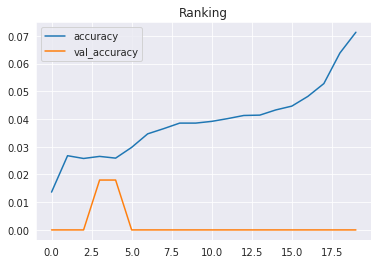

In [37]:
plt.plot(history_2.history['acc'], label='accuracy')
plt.plot(history_2.history['val_acc'], label = 'val_accuracy')
plt.title("Ranking")
# plt.ylim(-0.01,0.12)
plt.legend(loc='upper left')

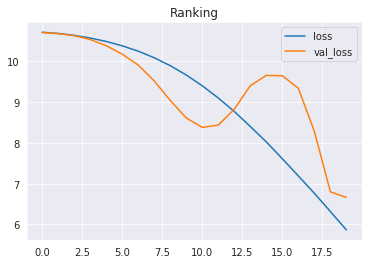

In [38]:
plt.plot(history_2.history['loss'], label='loss')
plt.plot(history_2.history['val_loss'], label = 'val_loss')
plt.title("Ranking")
# plt.ylim(-0.1,15)
plt.legend(loc='upper right')

In [39]:
pred_2= model_2.predict([pad_sequences(rcmd['test'])+ 1e-10,
                       pad_sequences(rcmd['rating'])+ 1e-10,
                       pad_sequences(rcmd['timestamp'])+ 1e-10,
#                        pad_sequences(rcmd['genresId'])+ 1e-10,
                       pad_sequences(rcmd['popularity'])+ 1e-10,
                       pad_sequences(rcmd['runtime'])+ 1e-10,
#                        pad_sequences(rcmd['castId'])+ 1e-10,
#                        pad_sequences(rcmd['crewId'])+ 1e-10,
                       pad_sequences(rcmd['vote_average'],dtype=float)+ 1e-10,
                       pad_sequences(rcmd['vote_count'],dtype=float)+ 1e-10,
                       ])
pred_2.shape

(1, 45465)

In [40]:
pred_2

array([[2.1463298e-05, 2.1604308e-05, 2.1968441e-05, ..., 2.1356227e-05,
        2.1526013e-05, 2.1032849e-05]], dtype=float32)

In [41]:
n = 100
kk = (-pred_2).argsort()[:,:n]
kk = kk[0]
print(k)
print(kk)

[ 4031   944  5315   286  3393   534 37798  5021  2260  4936    15 10995
  5264  5880  1744  6382  3813  6494 12024 11860  4765  3834  8772  2989
  1173 11018  3897  4606  4153  5845 33994 44219  6109  4783  6417  2183
  5304    14  8647  6967 11967  3224  7200  2199 16620  9554  1109 10577
 34559  6862   302  2224 41598    28 11772  1409 11305 32248 11047 22310
  3783  7223  1016  7757  6389 11440  7633 22587  5189  6419  5179  2108
 30362 11399  1224 12337 13271 10556 12131  4532   223 44848  6053  2653
 20816  9575  5088   787  6742  3904   638  7072 17003  7020   510  1243
 33785  9515  3891  2437]
[11967  6417  8772  5315  2108   638   510 12131  1016  1409 20816 41598
  5179 22310  2653 44848  3224   534  6742  6053  2989  5088  3813 11772
  7633 33994  5189   787  2199  1173 33785 10577 11047   223 13271 42219
 21016 35803 21571 28888 44667  9338 22836  3150 24953 40917  3865 41974
 42673 28805 11791 42966 21206 23543  7681 34063 14719 15414  3544 37697
  3644 20058 22606 18975 

In [42]:
print("Label:")
print("  "+result["movie"][rcmd["labels"][(rcmd[rcmd['userId']==USER].index.values[0])][0]])
print("Candidate generation:")
for i in k:
    print("  "+ result["movie"][i])
print("\nRanking:")
for i in kk:
    print("  "+result["movie"][i])
    
clear_output()
rating_list=[]

print("\nUser_"+str(USER)+" watched:")
for i in (rcmd["test"][(rcmd[rcmd['userId']==USER].index.values[0])]):
#     print(i)
    for j in kk:
        if i == j:
#             print(j)
            aa=rcmd["n_movie"][(rcmd[rcmd['userId']==USER].index.values[0])].index(j)
            print("  "+result["movie"][i]+
                  "    "+ "ratings: "+ str(rcmd["rating"][(rcmd[rcmd['userId']==USER].index.values[0])][aa]))
            rating_list.append(rcmd["rating"][(rcmd[rcmd['userId']==USER].index.values[0])][aa])
            


User_9682 watched:
  Sun Alley    ratings: 5.0
  The Boxer's Omen    ratings: 4.0
  Grave Decisions    ratings: 5.0
  The Hamburg Syndrome    ratings: 4.0
  The Song of Ceylon    ratings: 5.0
  The Lost Missile    ratings: 4.0
  Coming Down The Mountain    ratings: 4.0
  Chocolate    ratings: 4.0
  55 Days at Peking    ratings: 4.0
  Constantine's Sword    ratings: 4.0
  Holy Rollers    ratings: 4.0
  Family    ratings: 3.0
  Bigger Stronger Faster*    ratings: 4.0


In [43]:
rating_err=0

for i in range(1,len(rating_list)):
#     print(rating_list[i-1],rating_list[i])
    if rating_list[i-1] < rating_list[i]:
        rating_err += 1
        
rating_err/len(rating_list)

0.23076923076923078